In [1]:
import jax
from sklearn.datasets import fetch_openml
import matplotlib
import matplotlib.pyplot as plt
import jax.numpy as jnp
from jax import grad
import jax.lax as lax
from jax import random
import struct
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784')
import h5py

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [2]:
x,y = mnist['data'],mnist['target']

x_train,x_test = x[:60000], x[60000:]
y_train,y_test = y[:60000], y[60000:]

x_train =jnp.array(x_train, dtype=jnp.int32)
x_test = jnp.array(x_test,dtype = jnp.int32)
y_train = jnp.array(y_train,dtype = jnp.int32)
y_test = jnp.array(y_test,dtype=jnp.int32)

In [3]:
if jax.devices("gpu"):
    x_train = jax.device_put(x_train, device=jax.devices("gpu")[0])
    y_train = jax.device_put(y_train, device=jax.devices("gpu")[0])
    x_test = jax.device_put(x_test, device=jax.devices("gpu")[0])
    y_test = jax.device_put(y_test, device=jax.devices("gpu")[0])
else:
    print("No GPU available, using CPU.")

In [4]:
x_train = jnp.transpose(jnp.reshape(x_train, (60000, -1)))
x_test = jnp.transpose(jnp.reshape(x_test, (10000, -1)))
y_train = jnp.reshape(y_train, (1, 60000))
y_test = jnp.reshape(y_test, (1, 10000))
x_train = x_train / 255.0
x_test = x_test / 255.0

In [6]:
def one_hot(Y):
  Y_size = jnp.size(Y)
  Y_max = jnp.max(Y)
  one_hot_Y = jnp.zeros((Y_size, Y_max + 1), dtype=jnp.int32)
  #sets 0 to 1 at row-jnp.arange(Y_size); column - Y
  one_hot_Y=one_hot_Y.at[jnp.arange(Y_size), Y].set(1)
  one_hot_Y = jnp.transpose(one_hot_Y)
  return one_hot_Y

In [7]:
def initialize_parameters_deep(layer_dims):
   key = jax.random.PRNGKey(0)
   parameters = {}
   L = len(layer_dims)
   for l in range(1, L):
          weight_key, key = jax.random.split(key)
          parameters['W' + str(l)] = jax.random.normal(weight_key, shape=(layer_dims[l], layer_dims[l - 1])) * jnp.sqrt(2/layer_dims[l - 1])
          parameters['b' + str(l)] =jnp.zeros((layer_dims[l],1))
   return parameters

In [8]:
def linear_forward(A, W, b):
    Z=jnp.dot(W,A)+b
    cache=(A,W,b)
    return Z, cache

In [9]:
def relu(z):
  return jnp.maximum(0,z),z

In [10]:
def softmax(z):
   s = jnp.exp(z)/jnp.sum(jnp.exp(z), axis = 0, keepdims = True)
   return s, z

In [11]:
def linear_activation_forward(A_prev, W, b, activation):

     if activation == "relu":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache=relu(Z)
     elif activation == "softmax":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = softmax(Z)
     cache = (linear_cache, activation_cache)

     return A, cache

In [12]:
def L_model_forward(X, parameters):
   caches = []
   A = X
   L = len(parameters) //2
   for l in range(1,L):
     A_prev=A
     A, cache= linear_activation_forward(A_prev, parameters["W"+str(l)],parameters["b"+str(l)],"relu")
     caches.append(cache)
   AL, cache= linear_activation_forward(A, parameters["W"+str(L)],parameters["b"+str(L)],"softmax")

   caches.append(cache)

   return AL,caches

In [13]:
def compute_cost(AL, Y):
    m = Y.shape[1]
    cost = -jnp.sum(Y * jnp.log(AL) + (1 - Y) * jnp.log(1 - AL)) / m
    jnp.squeeze(cost)

    return cost

In [14]:
def linear_backward(dZ, cache):
   A_prev, W, b = cache
   m = A_prev.shape[1]
   dW=(1/m)*(jnp.dot(dZ,A_prev.T))
   db=(1/m)*jnp.sum(dZ,axis=1,keepdims=True)
   dA_prev=jnp.dot(W.T,dZ)
   return dA_prev,dW,db

In [15]:
def softmax_backward(AL, Y):
    dZ = AL- Y
    return dZ

In [16]:
def relu_backward(dA, cache):
    Z = cache
    dZ = jnp.where(Z > 0, dA, 0)
    return dZ

In [17]:
def L_model_backward(AL, Y, caches):
  grads = {}
  L = len(caches)
  m = AL.shape[1]
  Y = Y.reshape(AL.shape)
  current_cache = caches[L-1]
  linear_cache, activation_cache =current_cache
  dZ=softmax_backward(AL,Y)
  dA_prev_temp, dW_temp, db_temp =linear_backward(dZ,linear_cache)
  grads["dA" + str(L-1)] = dA_prev_temp
  grads["dW" + str(L)] = dW_temp
  grads["db" + str(L)] = db_temp
  for l in reversed(range(L-1)):
    current_cache = caches[l]
    linear_cache, activation_cache =current_cache
    dZ=relu_backward( dA_prev_temp,activation_cache)
    dA_prev_temp, dW_temp, db_temp =linear_backward(dZ,linear_cache)
    grads["dA" + str(l)] = dA_prev_temp
    grads["dW" + str(l+1)] = dW_temp
    grads["db" + str(l+1)] = db_temp
  return grads

In [18]:
def update_parameters(params, grads, learning_rate):
  parameters = params.copy()
  L = len(parameters) // 2
  for l in range(L):
        parameters["W" + str(l+1)] =parameters["W" + str(l+1)]-learning_rate*grads["dW"+str(l+1)]
        parameters["b" + str(l+1)] =parameters["b" + str(l+1)]-learning_rate*grads["db"+str(l+1)]
  return parameters

In [19]:
def get_predictions(Y_hat):
    return jnp.argmax(Y_hat,0)

def get_accuracy(predictions, Y):
  #returns true if predictions matches the correct predictions of dataset; sums the total number of true we get
  num = jnp.sum(predictions == Y)
  #ratio of total number of trues and total number of predictions
  accuracy = (num / jnp.size(Y))*100
  #print(predictions, Y)
  return accuracy

In [20]:
layers_dims = [784,40,20, 10]

In [23]:

def L_layer_model(X, Y, layers_dims, learning_rate = 0.75, num_iterations = 3000,print_cost=False):
  grads = {}
  costs = []
  m = X.shape[1]
  parameters=initialize_parameters_deep(layers_dims)
  for i in range(0, num_iterations):
    AL, caches=L_model_forward(X, parameters)
    grads=L_model_backward(AL, one_hot(Y), caches)
    parameters=update_parameters(parameters, grads, learning_rate)
    cost = compute_cost(AL,one_hot(Y))
    indices = (jnp.argmax(AL, axis=0), jnp.arange(AL.shape[1]))
    Y_predict=jnp.zeros_like(AL)
    Y_predict = Y_predict.at[indices].set(1)
    if print_cost and i % 100 == 0 or i == num_iterations - 1:
            print("Cost after iteration {}: {}".format(i, jnp.squeeze(cost)))
            print("accuracy : " , get_accuracy(get_predictions(AL),Y))

    if i % 100 == 0 or i == num_iterations:
            costs.append(cost)

  return parameters,costs, Y_predict,AL

In [24]:
parameters, costs, Y_predict,AL =L_layer_model(x_train,y_train, layers_dims, 0.2, 6000, True)

Cost after iteration 0: 3.341017723083496
accuracy :  11.04
Cost after iteration 100: 0.5548755526542664
accuracy :  90.49333
Cost after iteration 200: 0.4314113259315491
accuracy :  92.70167
Cost after iteration 300: 0.36761412024497986
accuracy :  93.89667
Cost after iteration 400: 0.3230125904083252
accuracy :  94.670006
Cost after iteration 500: nan
accuracy :  95.24834
Cost after iteration 600: nan
accuracy :  95.695
Cost after iteration 700: nan
accuracy :  96.03333
Cost after iteration 800: nan
accuracy :  96.31333
Cost after iteration 900: nan
accuracy :  96.59167
Cost after iteration 1000: nan
accuracy :  96.83834
Cost after iteration 1100: nan
accuracy :  97.058334
Cost after iteration 1200: nan
accuracy :  97.23334
Cost after iteration 1300: nan
accuracy :  97.38333
Cost after iteration 1400: nan
accuracy :  97.51
Cost after iteration 1500: nan
accuracy :  97.63667
Cost after iteration 1600: nan
accuracy :  97.74667
Cost after iteration 1700: nan
accuracy :  97.875
Cost afte

In [25]:
def accuracy_test(parameters, X, Y):
    AL, caches = AL, caches=L_model_forward(X, parameters)
    print("accuracy : " , get_accuracy(get_predictions(AL),Y))


    return AL, Y_predict

In [26]:
AL, Y_predict = accuracy_test(parameters, x_test, y_test)

accuracy :  97.19


In [55]:
def single_example_testing(example,truevalue):
   test_example=example.reshape((784,1))
   AL, caches = AL, caches=L_model_forward(test_example, parameters)
   answer=jnp.argmax(AL,0)
   print("true value is: ", truevalue[0])
   print("predicted value is: ", answer.item())

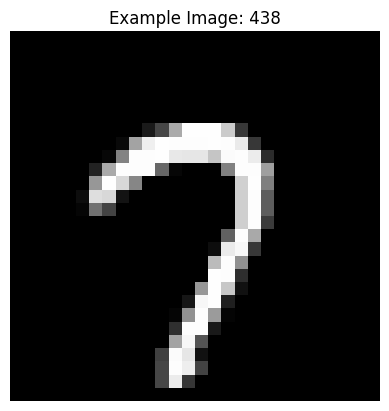

In [73]:
random_value = jax.random.randint(jax.random.PRNGKey(5), minval=0, maxval=10001, shape=())
example=x_test[:,random_value]
truevalue=y_test[:,random_value]
example=example.reshape((28,28))
plt.imshow(example, cmap='gray')
plt.title('Example Image: '+str(random_value))
plt.axis('off')
plt.show()

In [72]:
single_example_testing(example,truevalue)

true value is:  7
predicted value is:  7
